# CatsDogsPanda Image Classifier using Simple CNN

**Objective:**

  * Use Convolutional Neural Network (CNN) for CatsDogsPanda dataset.

In [17]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pathlib
import glob
import random
import os
from sklearn.preprocessing import LabelBinarizer  # preprocess
from sklearn.model_selection import train_test_split # for data split
from sklearn.
#from sklearn.neighbors import KNeighborsClassifier   # classifer
from sklearn.metrics import confusion_matrix, classification_report #metric

In [2]:
print('numpy: ', np.__version__)
print('opencv: ', cv2.__version__)

numpy:  1.14.2
opencv:  3.4.4


## Look at the Images

In [3]:
ImageDir = '../datasets/animals'

# recursively go over the datset folder and get the file names.
ImageList = list(pathlib.Path(ImageDir).rglob('*.jpg'))
print(len(ImageList))

3000


In [4]:
print(ImageList[1:4])

# get the filename.
print(ImageList[0].as_posix())

[PosixPath('../datasets/animals/cats/cats_00002.jpg'), PosixPath('../datasets/animals/cats/cats_00003.jpg'), PosixPath('../datasets/animals/cats/cats_00004.jpg')]
../datasets/animals/cats/cats_00001.jpg


../datasets/animals/cats/cats_00531.jpg
shape: (137, 180, 3)


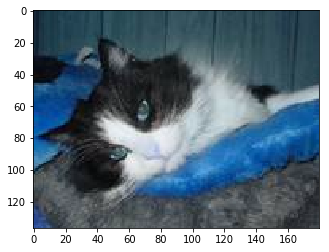

../datasets/animals/dogs/dogs_00309.jpg
shape: (396, 385, 3)


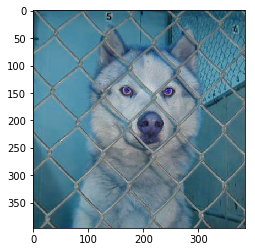

../datasets/animals/cats/cats_00119.jpg
shape: (215, 196, 3)


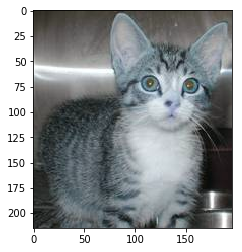

../datasets/animals/panda/panda_00688.jpg
shape: (375, 500, 3)


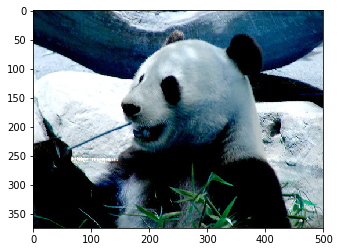

../datasets/animals/panda/panda_00332.jpg
shape: (375, 500, 3)


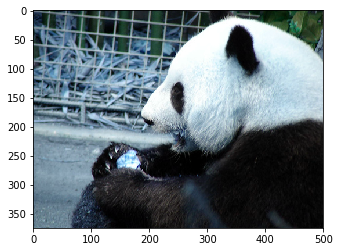

../datasets/animals/cats/cats_00079.jpg
shape: (332, 500, 3)


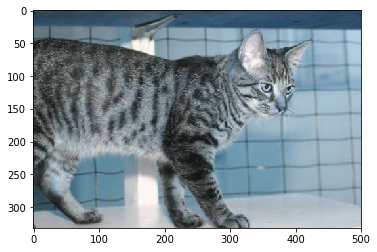

In [5]:
# look at few images
for i in range(6):
    idx = random.randint(1,len(ImageList))
    print(ImageList[idx])
    img = cv2.imread(ImageList[idx].as_posix())
    print('shape:', img.shape)
    plt.imshow(img)
    plt.show()

## Load all the images

In [6]:
## load all the images
## resize them to one size
def preprocess_image(img, width, height, interpolation=cv2.INTER_AREA):
    return( cv2.resize(img, (width, height), interpolation))


In [7]:
# load all images.
def load_all_images(imageList, verbose=-1):
    data = []
    labels = []

    # go over each image - read them and extract class label from the path
    for (i, imagepath) in enumerate(imageList):
        filename = imagepath.as_posix()
        img = cv2.imread(filename)
        label = filename.split(os.path.sep)[-2]
        img = preprocess_image(img, 32, 32)

        data.append(img)
        labels.append(label)

        if ( verbose > 0 and i > 0 and (i+1) % verbose == 0):
            print('Info: Processed {} / {}'.format(i+1, len(imageList)))


    return(np.array(data), np.array(labels))

In [8]:
##
print('Load All Images...')
(data, labels) = load_all_images(ImageList, verbose=250)

Load All Images...
Info: Processed 250 / 3000
Info: Processed 500 / 3000
Info: Processed 750 / 3000
Info: Processed 1000 / 3000
Info: Processed 1250 / 3000
Info: Processed 1500 / 3000
Info: Processed 1750 / 3000
Info: Processed 2000 / 3000
Info: Processed 2250 / 3000
Info: Processed 2500 / 3000
Info: Processed 2750 / 3000
Info: Processed 3000 / 3000


In [9]:
print(data.shape)

(3000, 32, 32, 3)


In [10]:
print(labels.shape)

(3000,)


### Normalize the input data in the range [0, 1]

In [11]:
data = data.astype("float") / 255.0

In [13]:
print(labels[0:3])

['cats' 'cats' 'cats']


## Split train and test data

In [14]:
## train / test => 75: 25 split
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=123)

In [16]:
trainY[0:5]

array(['cats', 'dogs', 'cats', 'cats', 'panda'], dtype='<U5')

In [21]:
 ## convert the labels from integers to vectors (one hot encoding)
trainY = LabelBinarizer().fit_transform(trainY)
testY  = LabelBinarizer().fit_transform(testY)

In [22]:
print(trainY[0:3])

[[1 0 0]
 [0 1 0]
 [1 0 0]]


In [23]:
print(testY[0:3])

[[0 1 0]
 [0 1 0]
 [1 0 0]]


## Build the model
  * Use just Convolution layer and feed to Fully connected network.
  * Input -> Conv2D -> ReLu -> FC -> SoftMax

In [26]:
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras import backend as K

Using Theano backend.


In [27]:
?Conv2D

In [30]:
def define_simple_conv_net(width, height, depth, classes):
    # start the model with sequential
    model = Sequential()
    
    inputShape = (height, width, depth)
    
    # add layers
    filters = 32
    kernel_size = (3,3)
    pad = 'same'
    
    # conv layer
    model.add(Conv2D(filters, kernel_size, padding=pad,  input_shape = inputShape))
    model.add(Activation('relu'))
    
    # now flatten all the inputs to feed to the network
    model.add(Flatten())
    
    # connect to the output layer - number of output classes
    model.add(Dense(classes))
    # get the probablity
    model.add(Activation('softmax'))
    
    # return the constructed network architecture
    return model

In [32]:
from keras.optimizers import SGD

In [34]:
print("Compiling model...")
opt = SGD(lr=0.005)
model = define_simple_conv_net(width=32, height=32, depth=3, classes=3)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

Compiling model...


### Train the network

In [35]:
# train the network
print("Train the network...")
H = model.fit(trainX, trainY, validation_data=(testX, testY), batch_size=32, epochs=100, verbose=1)


Train the network...
Train on 2250 samples, validate on 750 samples
Epoch 1/100
2250/2250 [==============================] - 2s 763us/step - loss: 1.0328 - acc: 0.4462 - val_loss: 0.9687 - val_acc: 0.5333
Epoch 2/100
2250/2250 [==============================] - 2s 833us/step - loss: 0.9360 - acc: 0.5293 - val_loss: 0.8934 - val_acc: 0.5507
Epoch 3/100
2250/2250 [==============================] - 2s 749us/step - loss: 0.8860 - acc: 0.5636 - val_loss: 0.8286 - val_acc: 0.5880
Epoch 4/100
2250/2250 [==============================] - 2s 756us/step - loss: 0.8514 - acc: 0.5751 - val_loss: 0.8640 - val_acc: 0.5480
Epoch 5/100
2250/2250 [==============================] - 2s 744us/step - loss: 0.8289 - acc: 0.5947 - val_loss: 0.8309 - val_acc: 0.5520
Epoch 6/100
2250/2250 [==============================] - 2s 750us/step - loss: 0.8085 - acc: 0.6089 - val_loss: 0.7859 - val_acc: 0.6067
Epoch 7/100
2250/2250 [==============================] - 2s 752us/step - loss: 0.7981 - acc: 0.6107 - val_loss

Epoch 60/100
2250/2250 [==============================] - 2s 786us/step - loss: 0.4220 - acc: 0.8373 - val_loss: 0.6864 - val_acc: 0.6733
Epoch 61/100
2250/2250 [==============================] - 2s 782us/step - loss: 0.4130 - acc: 0.8489 - val_loss: 0.7102 - val_acc: 0.6680
Epoch 62/100
2250/2250 [==============================] - 2s 778us/step - loss: 0.4098 - acc: 0.8493 - val_loss: 0.6880 - val_acc: 0.6747
Epoch 63/100
2250/2250 [==============================] - 2s 777us/step - loss: 0.4047 - acc: 0.8573 - val_loss: 0.8527 - val_acc: 0.6200
Epoch 64/100
2250/2250 [==============================] - 2s 782us/step - loss: 0.4062 - acc: 0.8436 - val_loss: 0.7367 - val_acc: 0.6667
Epoch 65/100
2250/2250 [==============================] - 2s 785us/step - loss: 0.3891 - acc: 0.8622 - val_loss: 0.6884 - val_acc: 0.6720
Epoch 66/100
2250/2250 [==============================] - 2s 785us/step - loss: 0.3854 - acc: 0.8596 - val_loss: 0.7052 - val_acc: 0.6693
Epoch 67/100
2250/2250 [==========

## Evaluate the model

In [36]:
pred = model.predict(testX, batch_size=32)
print(classification_report(testY.argmax(axis=1), pred.argmax(axis=1), target_names=["cat", "dog", "panda"]))

              precision    recall  f1-score   support

         cat       0.60      0.54      0.57       252
         dog       0.55      0.57      0.56       240
       panda       0.83      0.87      0.85       258

   micro avg       0.66      0.66      0.66       750
   macro avg       0.66      0.66      0.66       750
weighted avg       0.66      0.66      0.66       750



In [42]:
from sklearn.metrics import confusion_matrix
print(confusion_matrix(testY.argmax(axis=1), pred.argmax(axis=1)))

[[136  94  22]
 [ 78 137  25]
 [ 14  20 224]]


In [43]:
?confusion_matrix

In [46]:
#print(confusion_matrix(testY.argmax(axis=1), pred.argmax(axis=1), labels=["cat", "dog", "panda"]))

In [40]:
from sklearn.metrics import accuracy_score
print(accuracy_score(testY.argmax(axis=1), pred.argmax(axis=1)))

0.6626666666666666


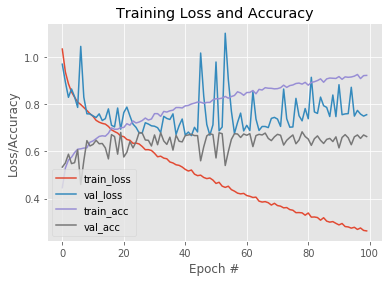

In [47]:
# plot the training loss and accuracy
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 100), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 100), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 100), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, 100), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()